In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(256,128,49),use_voxels=True)
#fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
#atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)
atlas = ants.resample_image(atlas,(256,128,49),use_voxels=True)

In [3]:
### Load supervoxel labels ###
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [4]:
filter_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/20210613_filters.npy'
filters = np.load(filter_file)
print(filters.shape)

(49, 2000, 50)


In [5]:
images = []
for tp in tqdm(range(50)):
    all_z = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            if len(cluster_indicies) > 200:
                colored_by_betas[cluster_indicies] = 0
            else:
                colored_by_betas[cluster_indicies] = filters[z,cluster_num,tp]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_z.append(colored_by_betas)
    all_z = np.asarray(all_z)
    images.append(all_z)
images = np.asarray(images)

100%|██████████| 50/50 [01:34<00:00,  1.90s/it]


In [6]:
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/20210613_filters_voxel_res.npy'
images = np.load(load_file)
images.shape

### NEED TO LOAD HERE - I THINK 2021613 FILTERS WERE OVERWRITTEN

(50, 49, 256, 128)

In [7]:
print(images.shape)
images_ = np.moveaxis(images,1,3)
print(images_.shape)
images_ = np.moveaxis(images_,0,3)
print(images_.shape)

(50, 49, 256, 128)
(50, 256, 128, 49)
(256, 128, 49, 50)


In [8]:
moving = ants.from_numpy(images_[:,:,::-1,:])
moving.set_spacing((2.6076, 2.6154, 5.3125,1)) ### matching this to the slightly off luke mean

out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')

corr_map = maps_voxel_res.numpy()

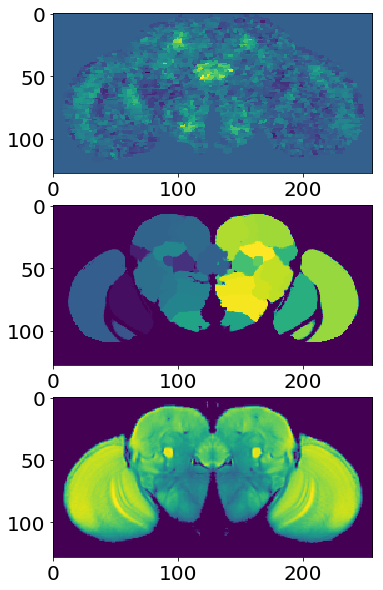

In [74]:
z=30
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(corr_map[:,:,z,25].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

In [78]:
#maps = images_#maps.numpy()
maps = corr_map

left = maps[:128,:,:,:]
right = maps[128:,:,:,:]

right = right[::-1,:,:,:]

left.shape

### spatial smoothing if desired
# quick and dirty - should remove temporal axis and probably rescale z
left = gaussian_filter(left,sigma=2,truncate=1)
right = gaussian_filter(right,sigma=2,truncate=1)

corrs = []
sigs = []
for z in tqdm(range(49)):
    for x in range(128):
        for y in range(128):
            r, p = scipy.stats.pearsonr(left[x,y,z,:], right[x,y,z,:])
            corrs.append(r)
            sigs.append(p)
corrs = np.asarray(corrs)
sigs = np.asarray(sigs)

corrs_ = np.reshape(corrs,(49,128,128))
sigs_ = np.reshape(sigs,(49,128,128))

left_maxs = np.max(np.abs(left),axis=-1)
right_maxs = np.max(np.abs(right),axis=-1)

100%|██████████| 49/49 [00:53<00:00,  1.05s/it]


In [79]:
corrs__ = np.moveaxis(corrs_,0,-1)
corrs__.shape

(128, 128, 49)

In [80]:
mask_hemi = np.ones((128,128,49))
mask_hemi[np.where(corrs__<.5)]= 0
mask_hemi[np.where(right_maxs<.0004)] = 0
mask_hemi[np.where(left_maxs<.0004)] = 0
mask = np.concatenate((mask_hemi, mask_hemi[::-1,:,:]), axis=0)
mask.shape

(256, 128, 49)

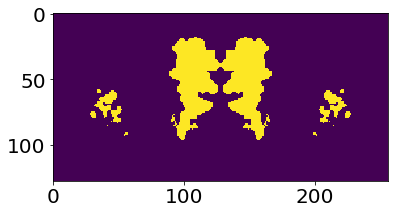

In [89]:
plt.imshow(mask[:,:,20].T)

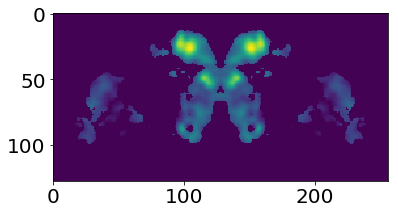

In [84]:
### avg signals from left and right
LR_mean_hemi = np.mean(np.array([left,right]), axis=0)
LR_mean_hemi.shape
LR_mean = np.concatenate((LR_mean_hemi, LR_mean_hemi[::-1,:,:]), axis=0)
LR_mean.shape

### mask
LR_mean_masked = LR_mean * mask[...,np.newaxis]
LR_mean_masked.shape

plt.imshow(LR_mean_masked[:,:,25,25].T)

In [85]:
### need list of non-masked signals for clustering
signals = np.reshape(LR_mean_masked,(256*128*49,50))
sums = np.sum(signals,axis=-1)
to_delete = np.where(sums==0)[0]
signals_for_clustering = np.delete(signals, to_delete,axis=0)
### normalize
maxs = np.max(np.abs(signals_for_clustering),axis=-1)
signals_for_clustering = signals_for_clustering/maxs[:,np.newaxis]
signals_for_clustering.shape

(138946, 50)

In [309]:
t0 = time.time()
clustering_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/clustering'
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                memory=clustering_dir,
                                linkage='ward')
model = model.fit(signals_for_clustering)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
0.6455914974212646


In [310]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [311]:
###############
n_clusters = 10
###############

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.jet(np.linspace(0, 1, n_clusters))
cluster_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors)

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

In [312]:
### mean cluster responses
cluster_responses = []
for n in np.unique(cluster_ids):
    cluster_response = np.mean(signals_for_clustering[cluster_ids==n,:], axis=0)
    cluster_responses.append(cluster_response)
    
cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

add_deleted_voxels = np.zeros(49*128*256)
#add_deleted_voxels[:] = np.nan #<---------
to_replace = np.where(sums!=0)[0]

In [313]:
add_deleted_voxels[to_replace] = cluster_ids #model.labels_ ### put signal here
add_deleted_voxels[to_delete] = np.nan #<------
to_plot = np.reshape(add_deleted_voxels, LR_mean_masked.shape[:3])

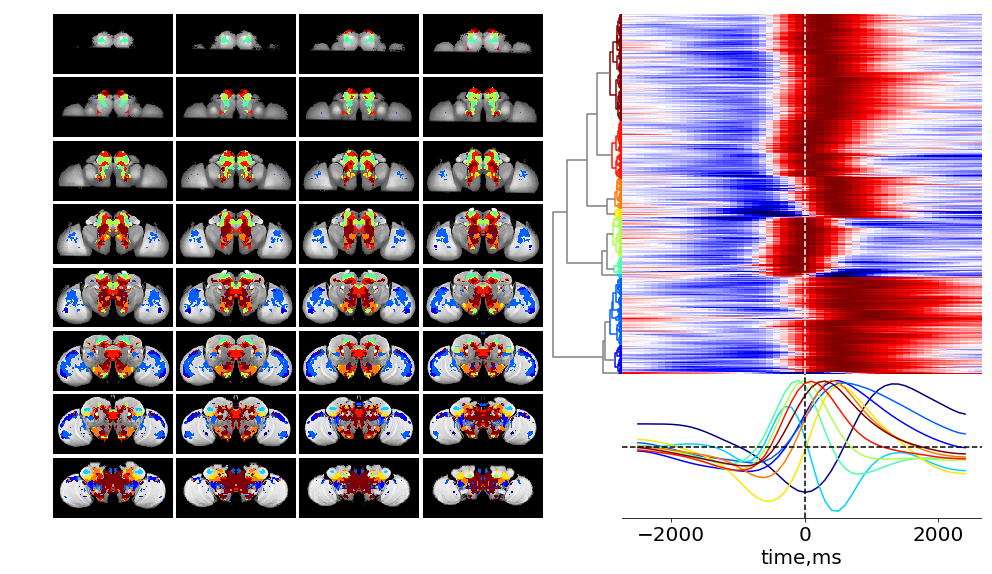

In [314]:
fig = plt.figure(figsize=(10,10))

### dendrogram ###
ax_dendrogram = fig.add_axes([1, .3, .1, .5])
ax_dendrogram.axis('off')
dend = dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey',
           orientation='left');

### all resp ###
ax_dend = fig.add_axes([1.1, .3, .5, .5])
aspect = signals_for_clustering.shape[1]/signals_for_clustering.shape[0]
ax_dend.imshow(signals_for_clustering[dend['leaves'][::-1],:],vmin=-1,vmax=1,aspect=aspect,cmap='seismic')
ax_dend.axis('off')
for line in [25]:
    ax_dend.axvline(line,color='w',linestyle='--')    
#plt.title('top 25% fwd, ward, normalized')

### Mean resp ###
ax = fig.add_axes([1.1, 0.1, .5, .2])
timepoints = list(range(-2500,0,100)) + list(range(0,2500,100))
for n in range(len(np.unique(cluster_ids))):
    ax.plot(timepoints, cluster_responses[n],color=cluster_colors[n])
ax.axvline(0,color='k',linestyle='--')
ax.axhline(0,color='k',linestyle='--')
ax.set_xlabel('time,ms')
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

### BRAIN ###
grid = ImageGrid(fig, rect=[.3,.1,.7,.7], nrows_ncols=(8, 4), axes_pad=.05)
for j,i in enumerate(range(8,49-9)):
    grid[j].imshow(out['warpedmovout'].numpy()[:,:,i].T,cmap='gray')
    cax = grid[j].imshow(to_plot[:,:,i].T,cmap=cmap,vmin=1,vmax=n_clusters);
for i in range(32):
    grid[i].axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [298]:
cnts = []
for i in range(1,11):
    cnts.append(len(np.where(cluster_ids==i)[0]))

### Starting Map ###
for i in range(10):
    print(F'Cluster = {i+1} | Cnt = {cnts[i]} | {cluster_colors[i]}')
print('=====================================')

### New Map ###
# cnt and color should stay together, but want new cluster IDs based on cnt
sort_ids = np.argsort(cnts)[::-1]
to_plot_new = np.zeros(to_plot.shape)
to_plot_new[:] = np.nan
new_colors = []
for j, i in enumerate(sort_ids):
    print(F'Cluster = {j+1} | Cnt = {cnts[i]} | {cluster_colors[i]}')
    to_plot_new[np.where(to_plot==(i+1))] = j+1
    new_colors.append(cluster_colors[i])
    
#new_colors.insert(0,'#808080')
cmap_new = colors.ListedColormap(new_colors)

Cluster = 1 | Cnt = 638 | #000080
Cluster = 2 | Cnt = 10678 | #0000ff
Cluster = 3 | Cnt = 26088 | #0060ff
Cluster = 4 | Cnt = 1342 | #00d4ff
Cluster = 5 | Cnt = 6506 | #4dffaa
Cluster = 6 | Cnt = 15094 | #aaff4d
Cluster = 7 | Cnt = 3718 | #ffe600
Cluster = 8 | Cnt = 11688 | #ff7a00
Cluster = 9 | Cnt = 22024 | #ff1300
Cluster = 10 | Cnt = 41170 | #800000
Cluster = 1 | Cnt = 41170 | #800000
Cluster = 2 | Cnt = 26088 | #0060ff
Cluster = 3 | Cnt = 22024 | #ff1300
Cluster = 4 | Cnt = 15094 | #aaff4d
Cluster = 5 | Cnt = 11688 | #ff7a00
Cluster = 6 | Cnt = 10678 | #0000ff
Cluster = 7 | Cnt = 6506 | #4dffaa
Cluster = 8 | Cnt = 3718 | #ffe600
Cluster = 9 | Cnt = 1342 | #00d4ff
Cluster = 10 | Cnt = 638 | #000080


In [283]:
to_plot_new.shape

(256, 128, 49)

In [284]:
### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)
#atlas = ants.resample_image(atlas,(256,128,49),use_voxels=True)

In [285]:
atlas.shape

(314, 146, 91)

In [302]:
to_plot_new_ants = ants.from_numpy(to_plot_new)
to_plot_new_ants = ants.resample_image(to_plot_new_ants,(314, 146, 91),use_voxels=True,interp_type=1)
to_plot_new = to_plot_new_ants.numpy()
to_plot_new.shape

(314, 146, 91)

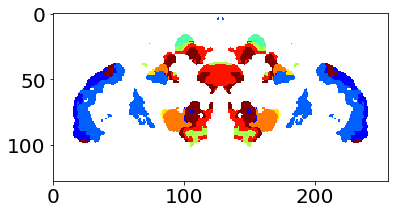

In [268]:
plt.imshow(to_plot[:,:,30].T,cmap=cmap,vmin=1,vmax=n_clusters)

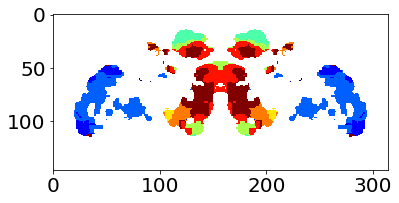

In [305]:
plt.imshow(to_plot_new[:,:,50].T,cmap=cmap_new,vmin=1,vmax=n_clusters)

In [316]:
corr_map.shape

(256, 128, 49, 50)

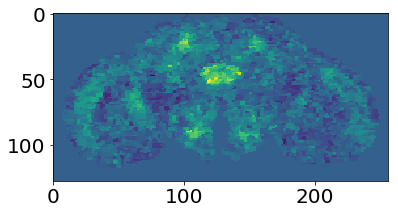

In [318]:
plt.imshow(corr_map[:,:,30,25].T)



In [326]:
# BONUS: get exploded diagram of a few timepoints
to_plot_new_ants = ants.from_numpy(corr_map[:,:,:,25])
to_plot_new_ants = ants.resample_image(to_plot_new_ants,(314, 146, 91),use_voxels=True,interp_type=0)
corr = to_plot_new_ants.numpy()
corr.shape

(314, 146, 91)

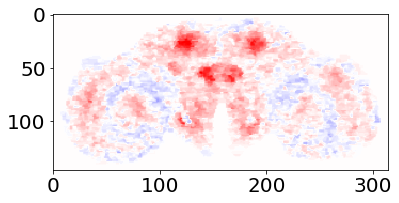

In [356]:
plt.imshow(corr[:,:,50].T,cmap='seismic',vmin=-0.005,vmax=0.005)

In [344]:
np.max(corr)

0.0034043698

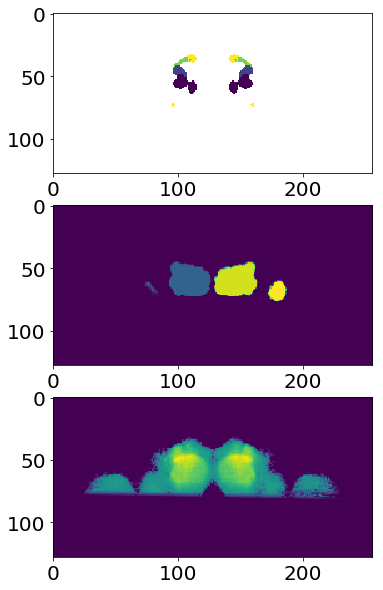

In [281]:
z=10
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(to_plot[:,:,z].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

In [289]:
atlas = atlas.numpy()

(-0.5, 313.5, 145.5, -0.5)

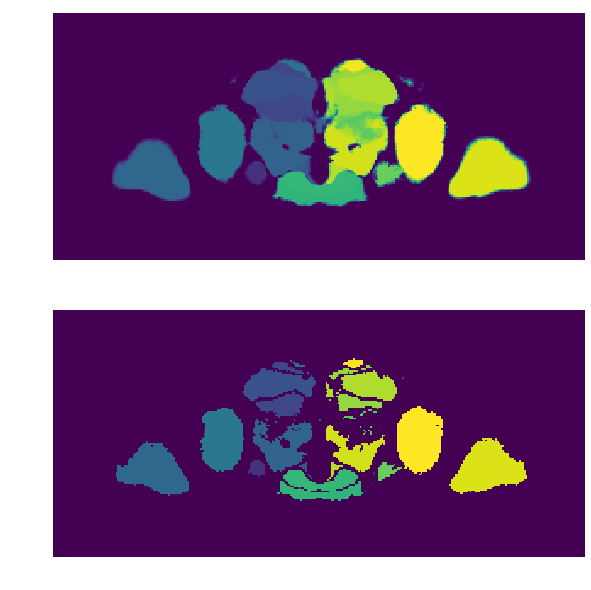

In [290]:
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,30].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,30].T)
plt.axis('off')

In [342]:
####################################
### FOR SINGLE MAP (ie, not RGB) ###
####################################

def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # use this for plotting clusters
#         # temporal
#         masked_roi = mask_dilated*np.nan_to_num(to_plot_new)#*temporal_map #CORR
#         #masked_roi = mask_dilated*np.nan_to_num(corr)#*temporal_map #CORR

#         masked_roi_flat = np.max(masked_roi,axis=2)
#         roi_data.append(masked_roi_flat)
        #print(np.sum())
        
        #PCA or any diverging (Turn off if above is on) <---------------
        masked_roi = mask_dilated*np.nan_to_num(corr)
        maxs = np.max(masked_roi,axis=2)
        mins = np.min(masked_roi,axis=2)
        maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
        masked_roi_flat = maxs
        roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
        
    #for plotting clusters
#     roi_datas = np.max(np.asarray(roi_data),axis=0)
#     data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA (Turn off if above is on) <---------------
    roi_data = np.asarray(roi_data)
    maxs = np.max(roi_data,axis=0)
    mins = np.min(roi_data,axis=0)
    maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
    data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [110]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

In [ ]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/20210613_filters_high_res_vol'
nib.Nifti1Image(corr_map, np.eye(4)).to_filename(save_file)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


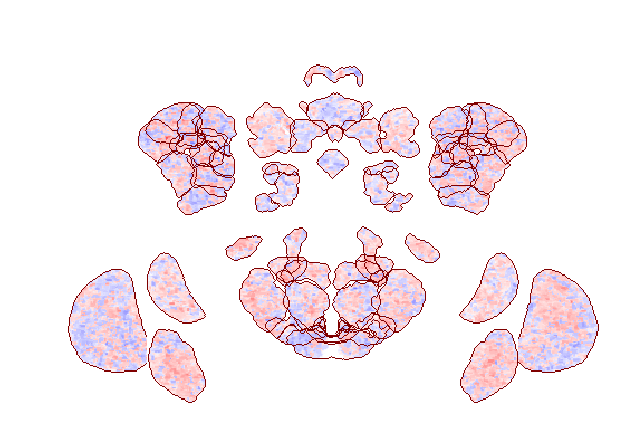

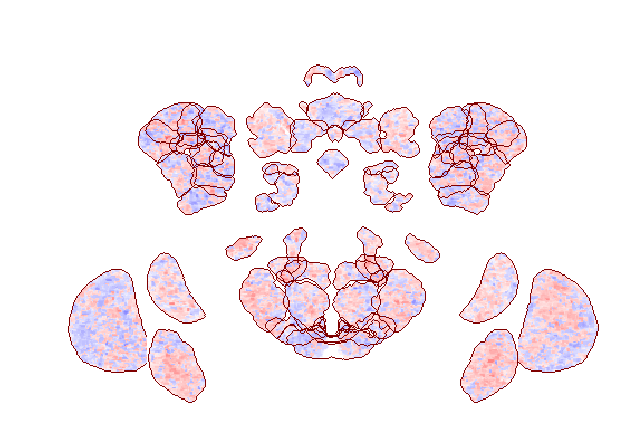

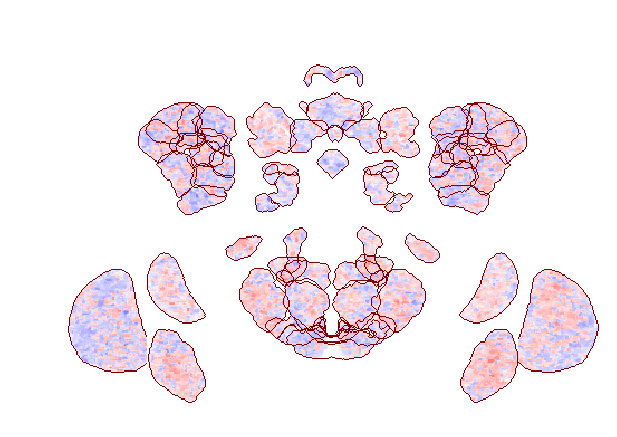

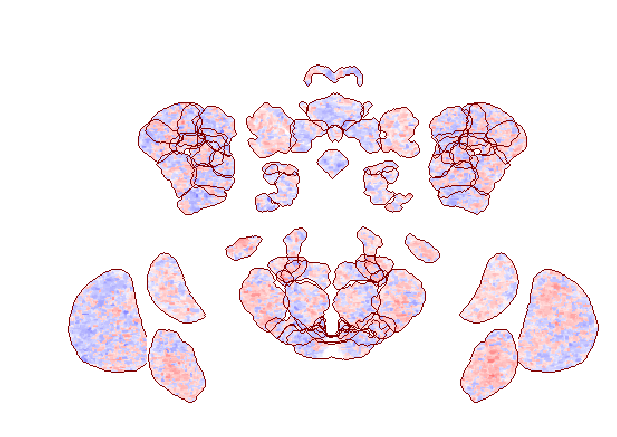

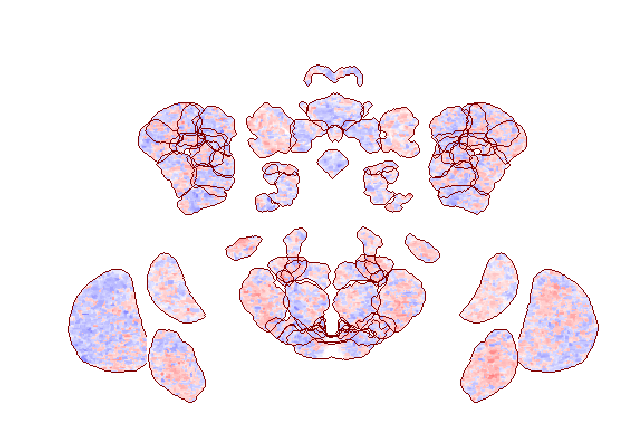

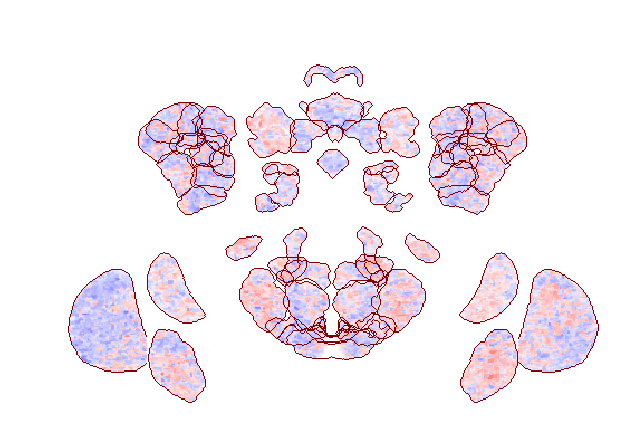

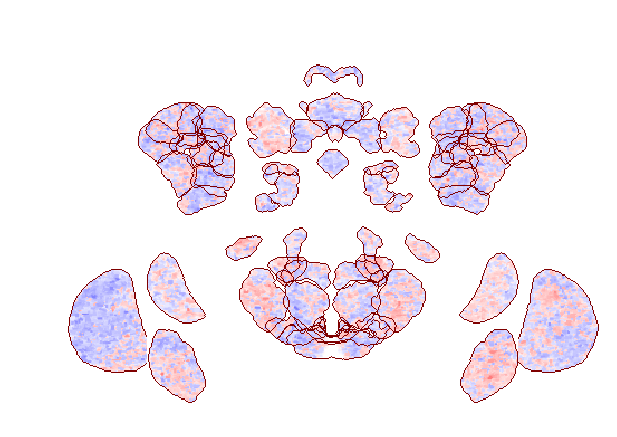

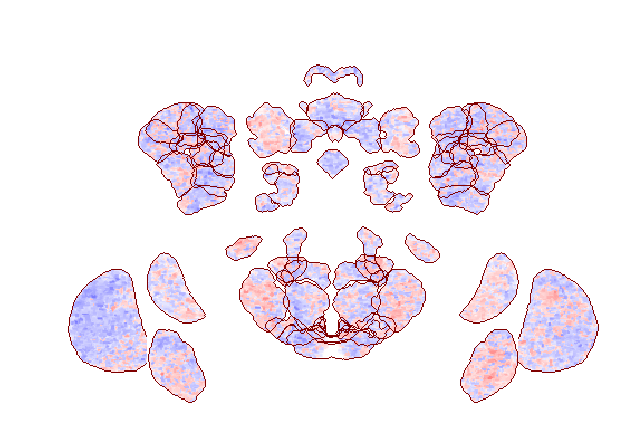

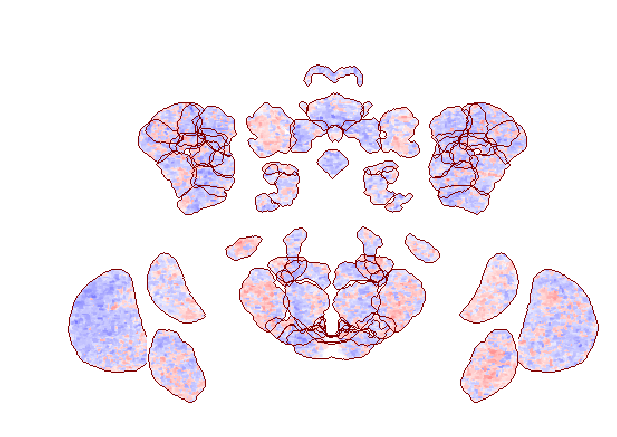

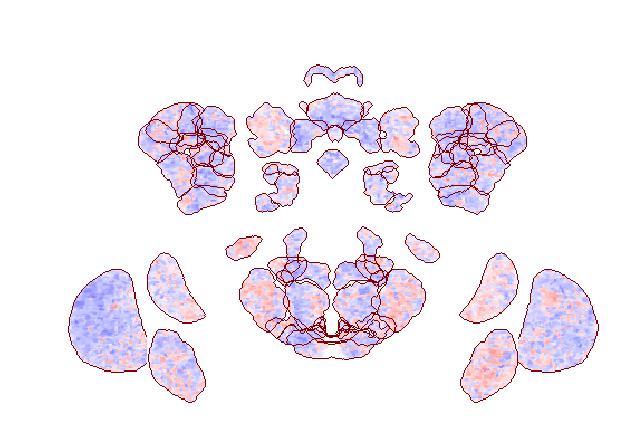

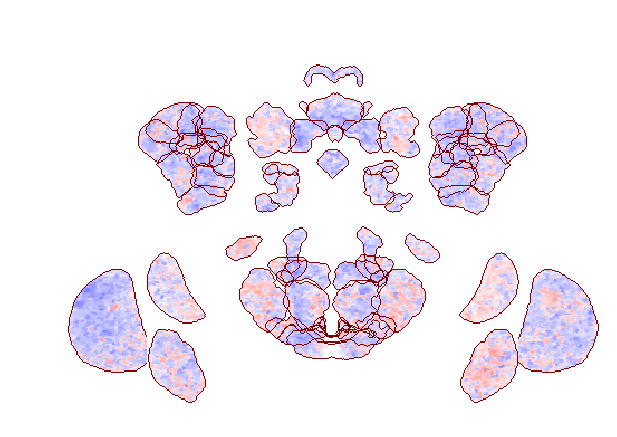

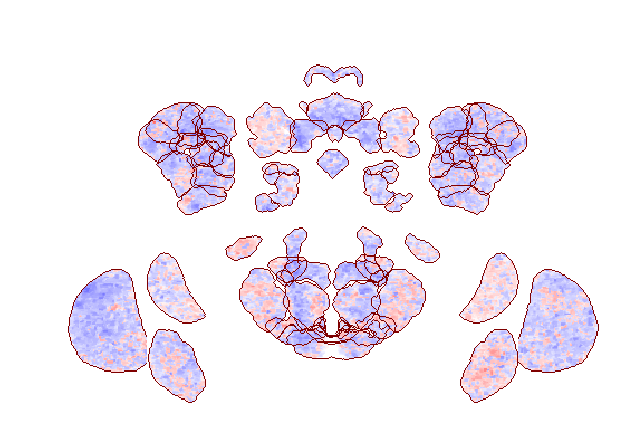

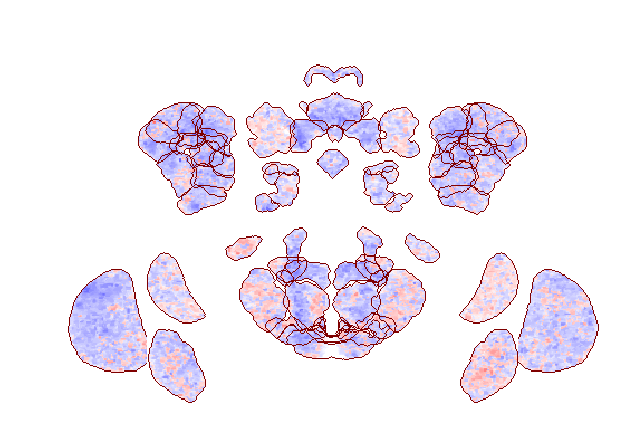

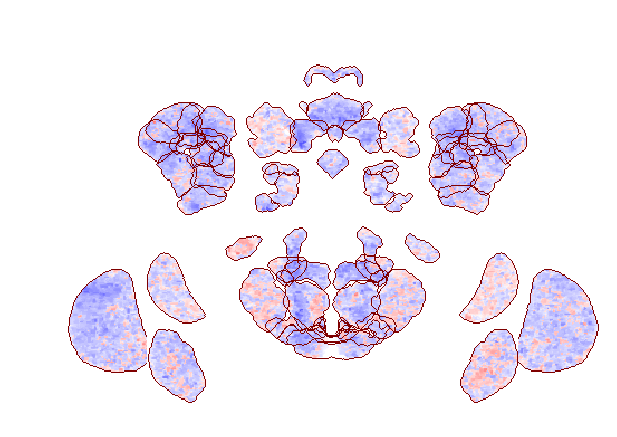

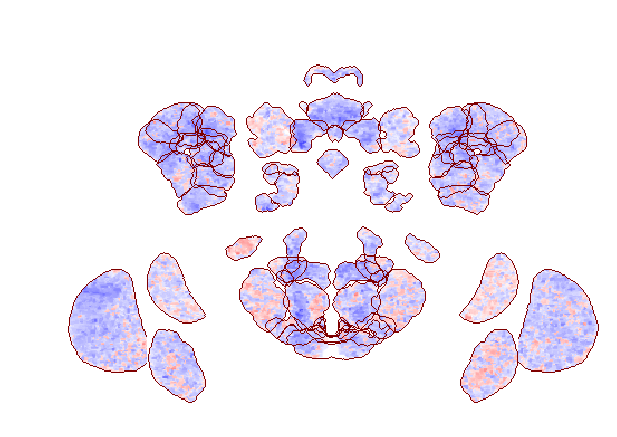

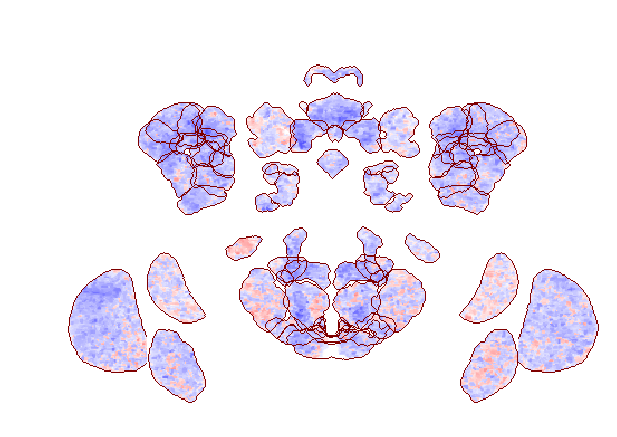

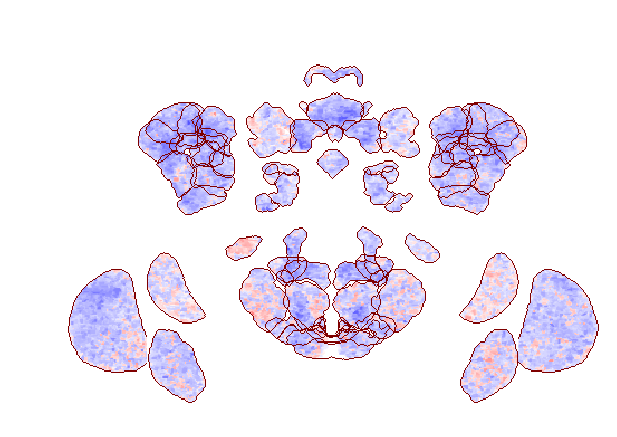

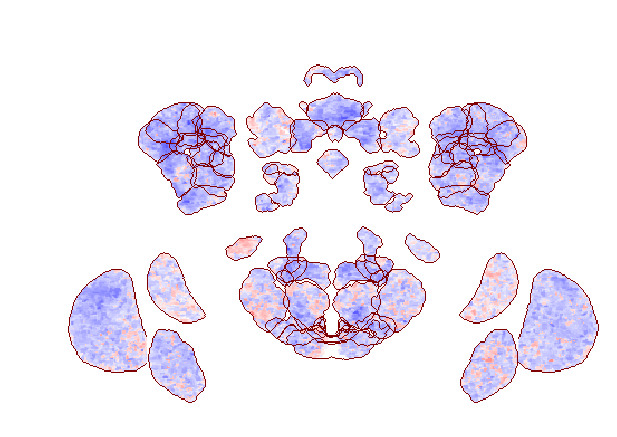

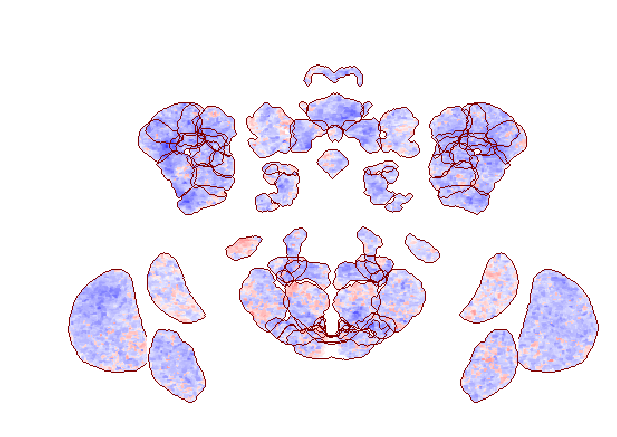

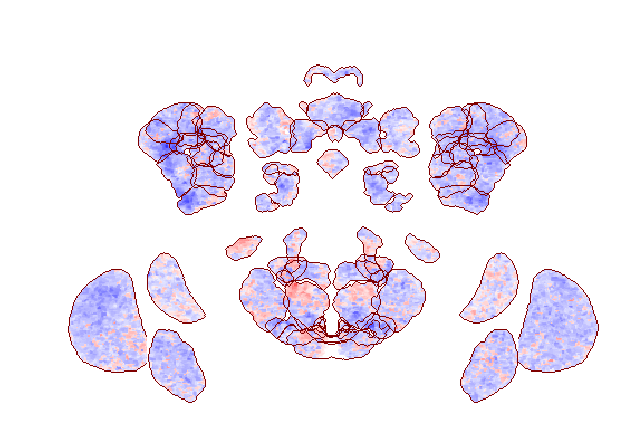

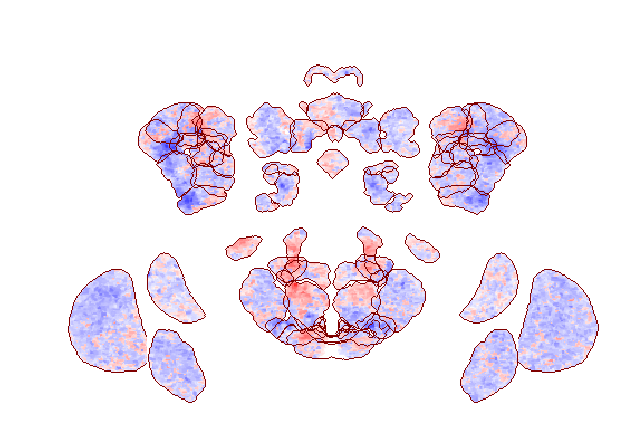

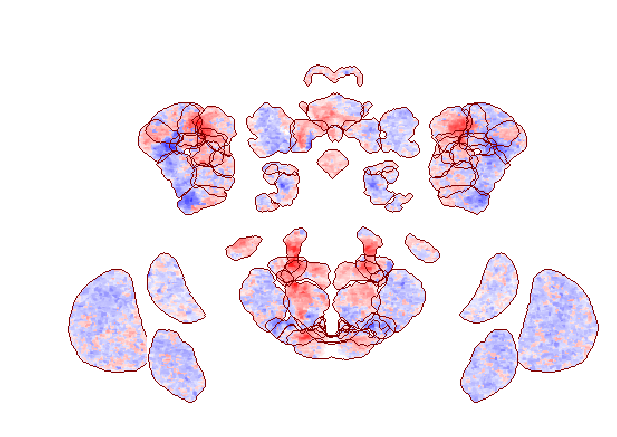

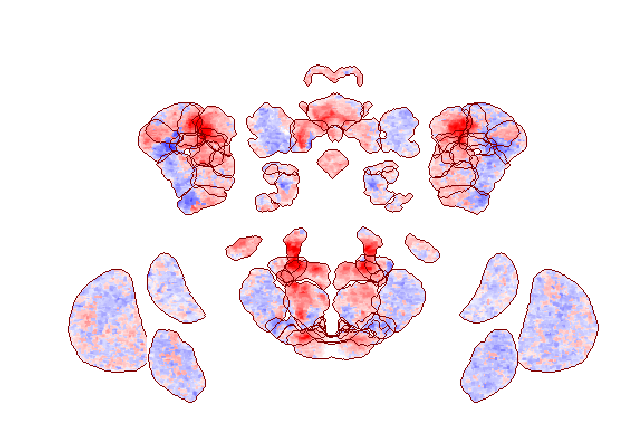

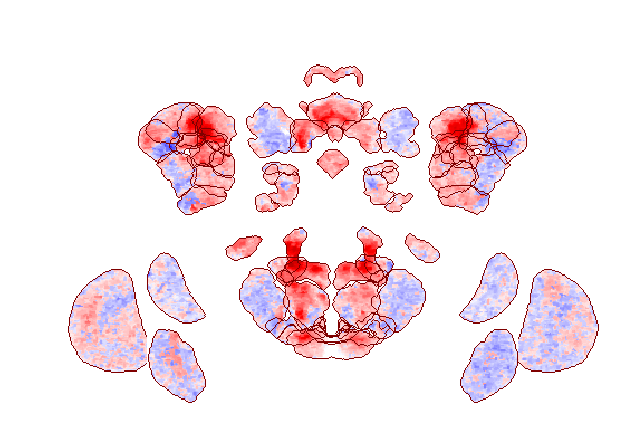

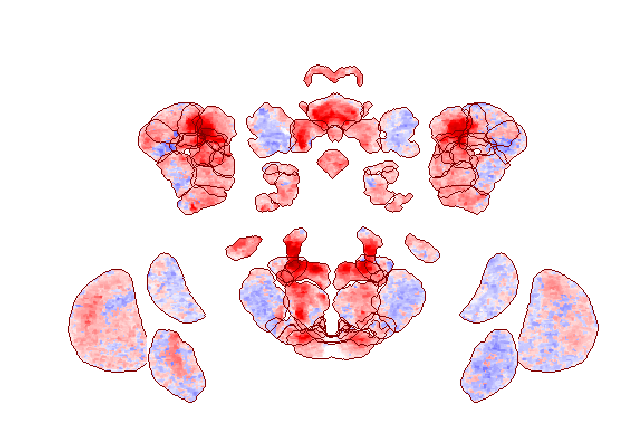

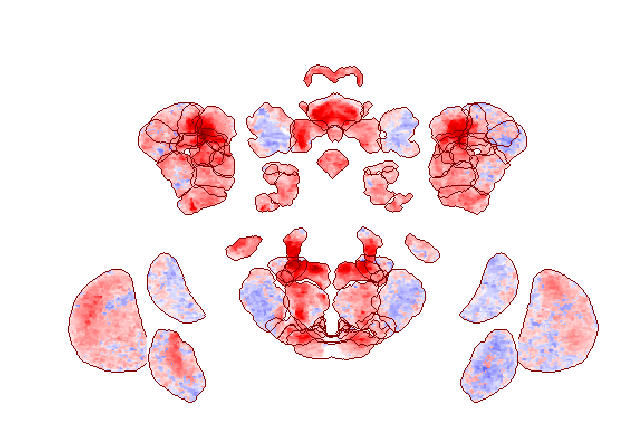

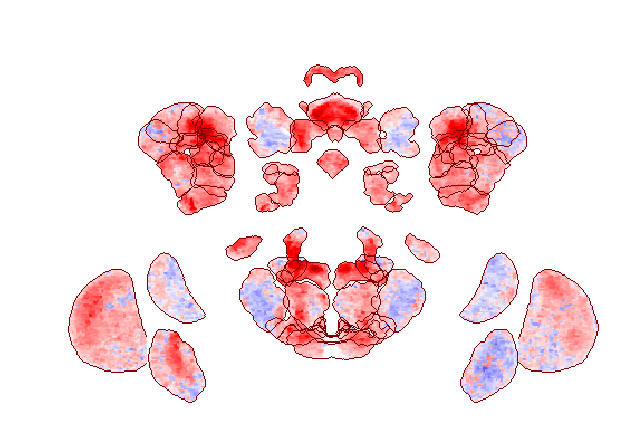

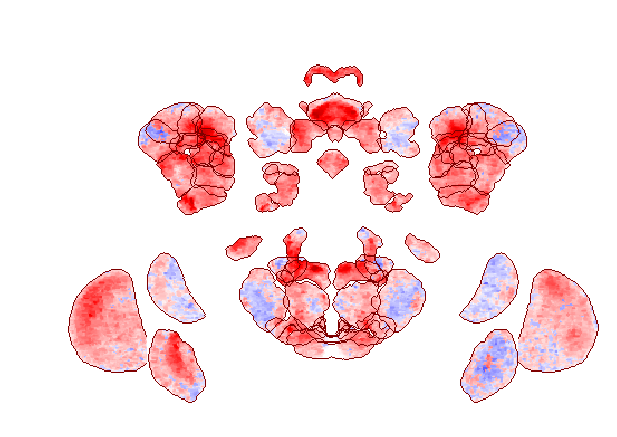

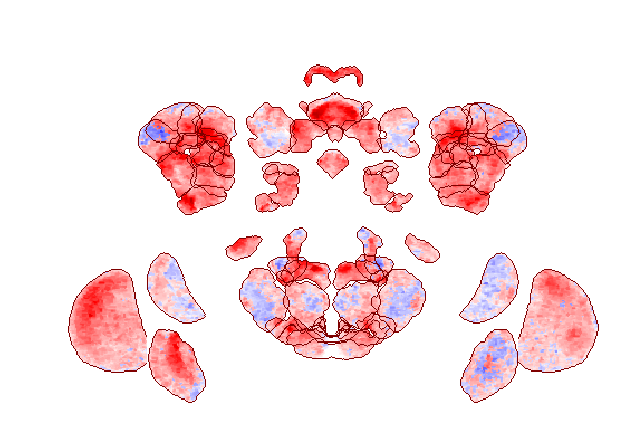

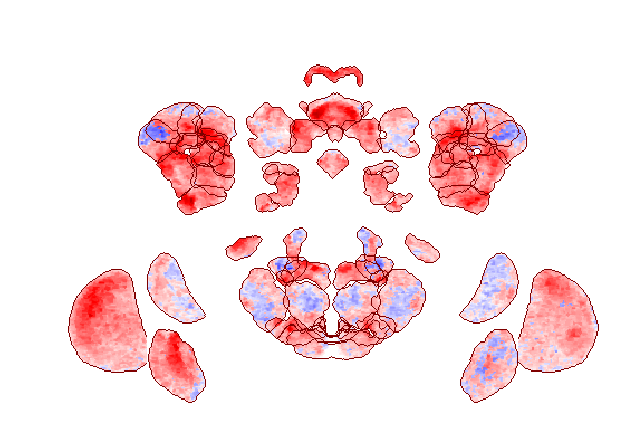

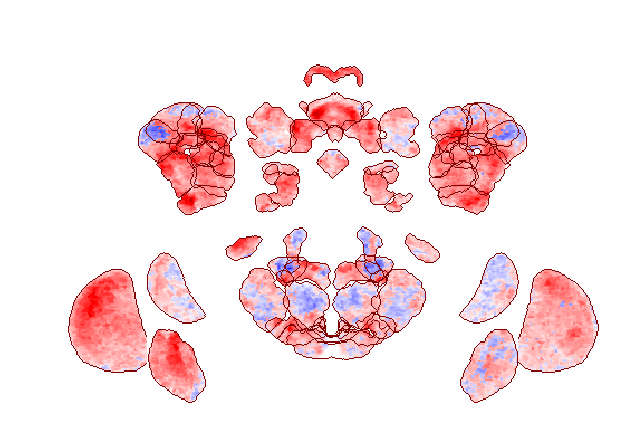

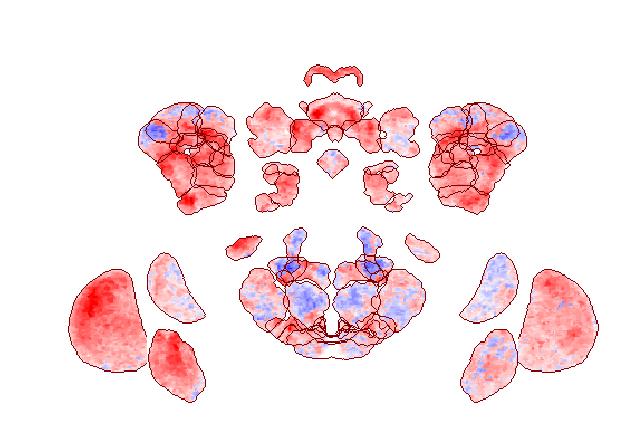

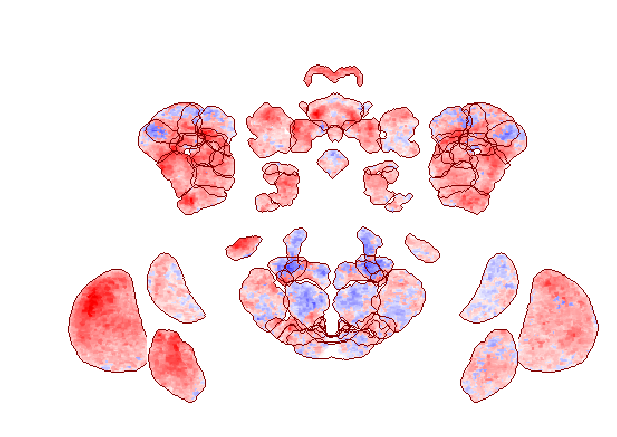

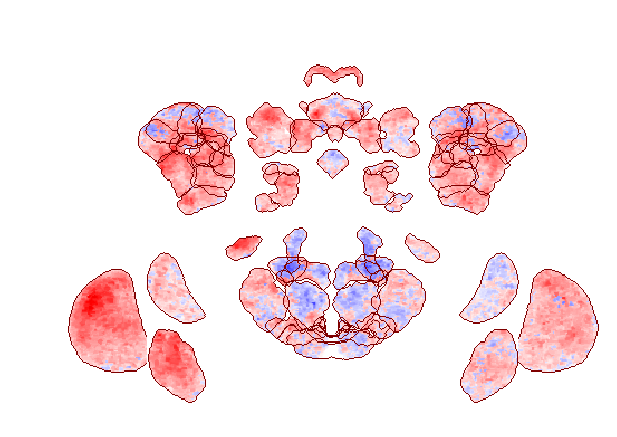

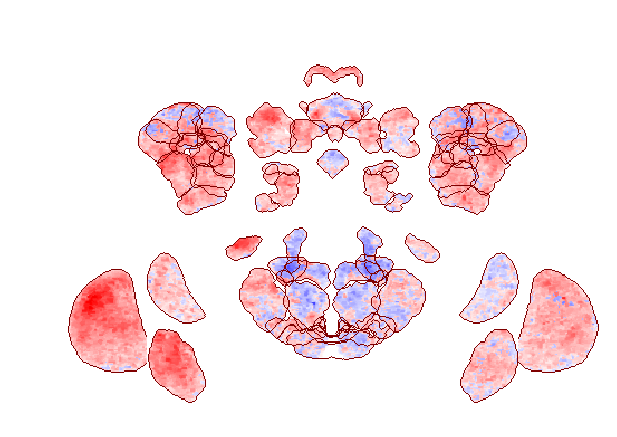

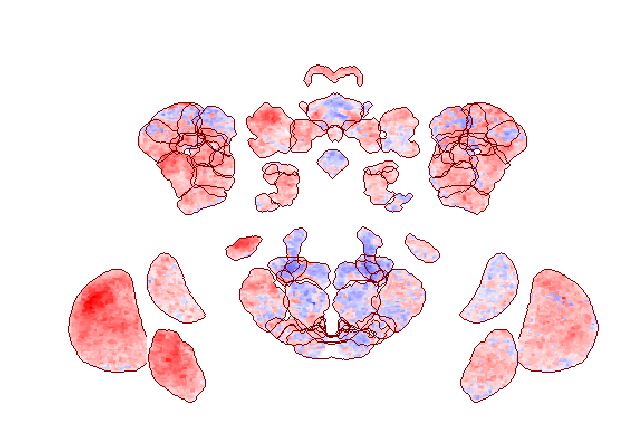

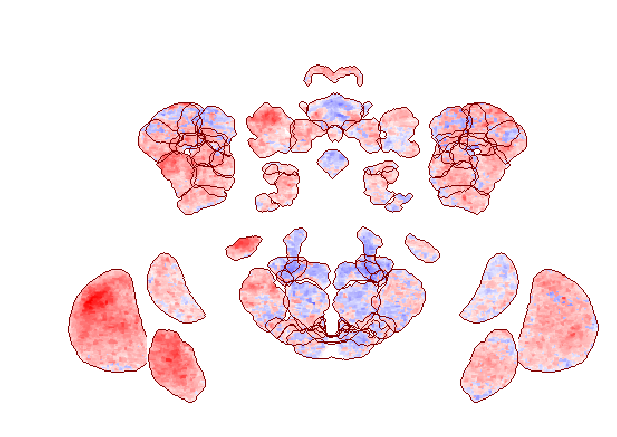

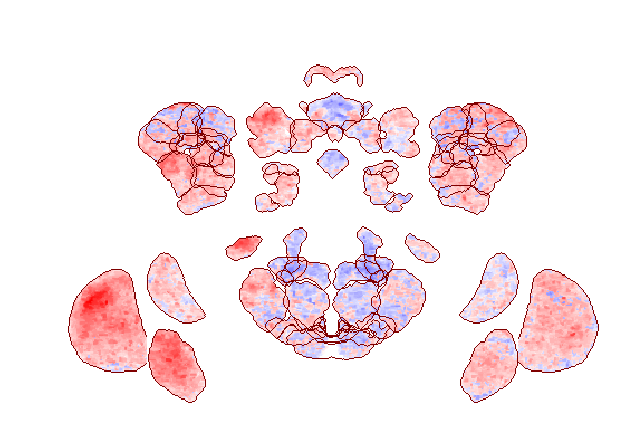

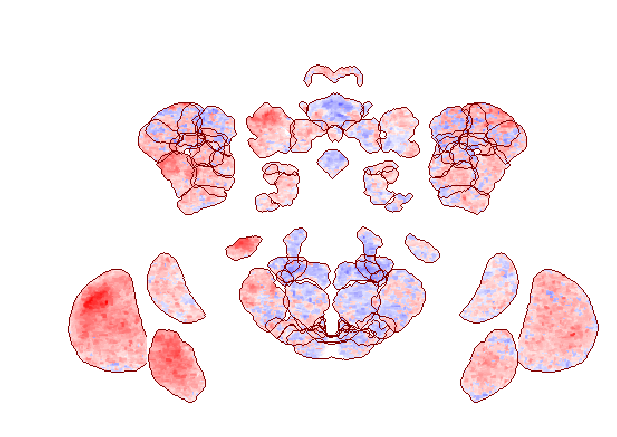

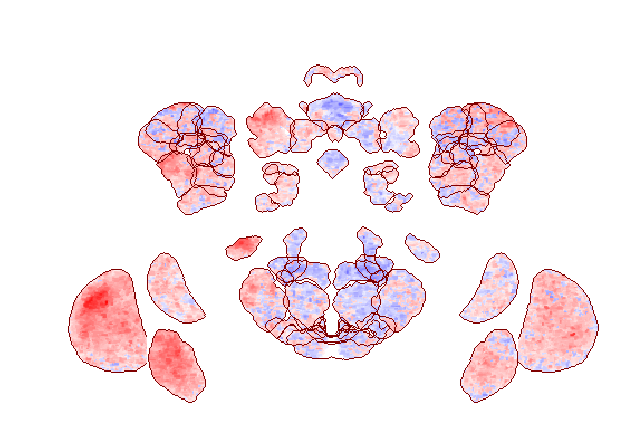

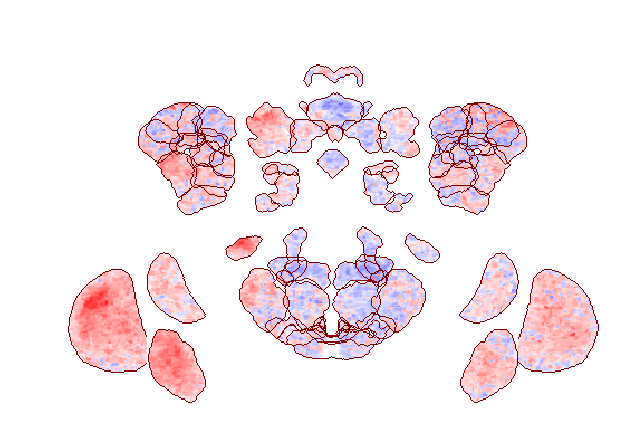

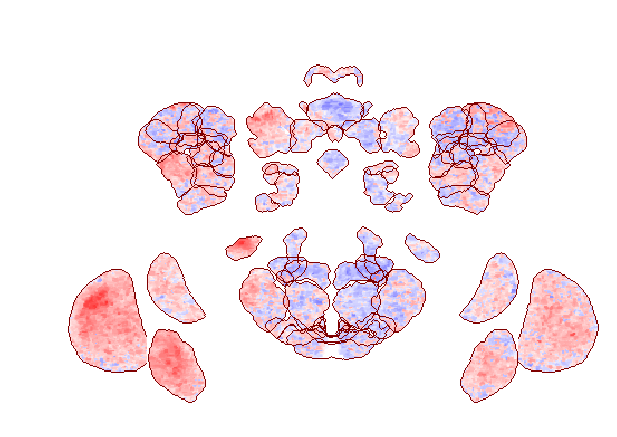

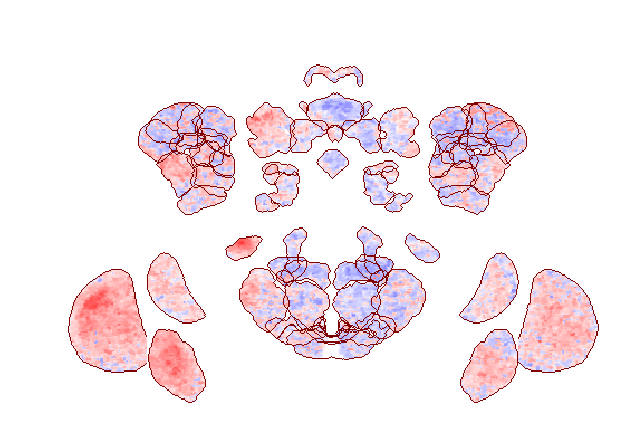

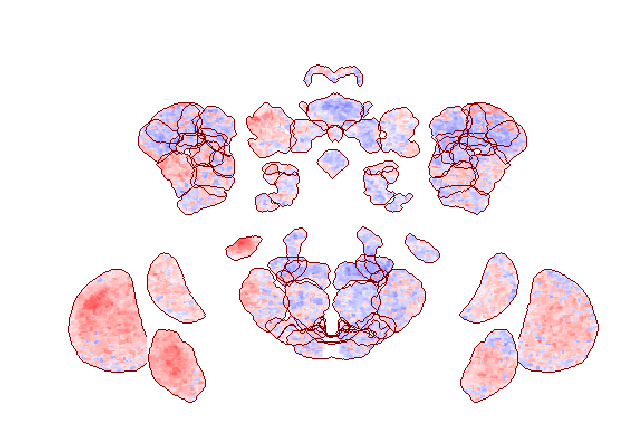

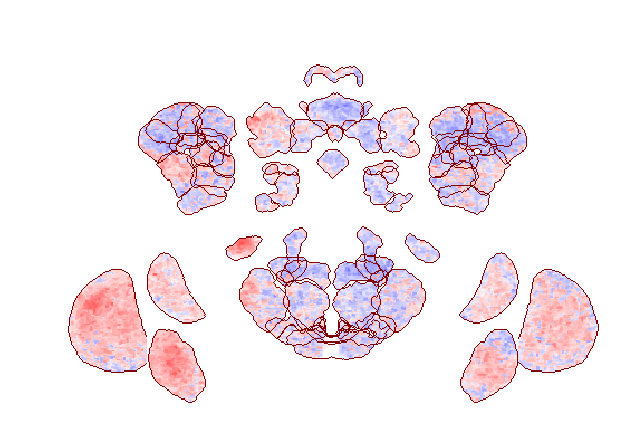

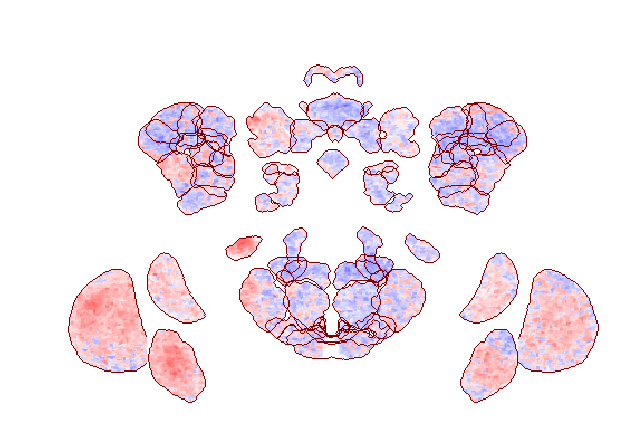

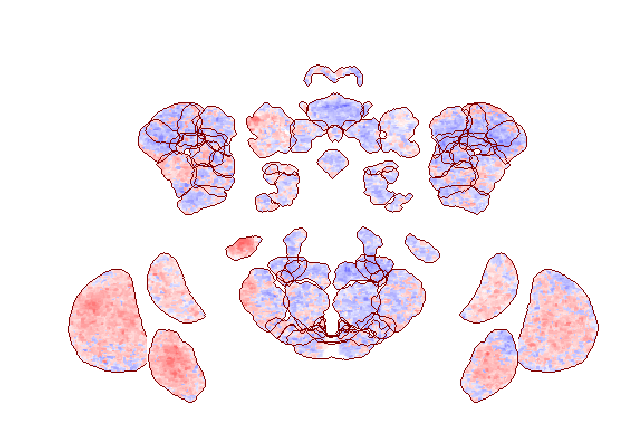

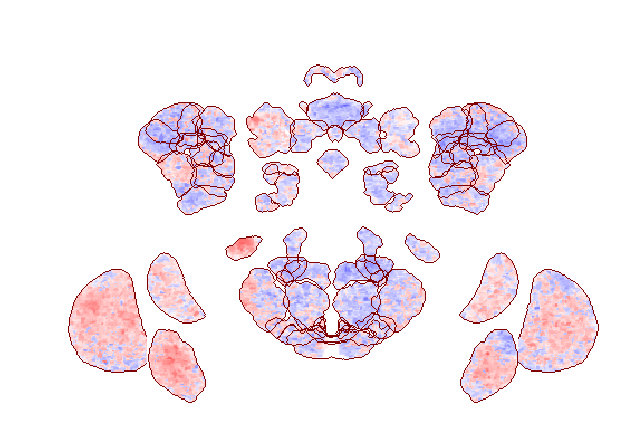

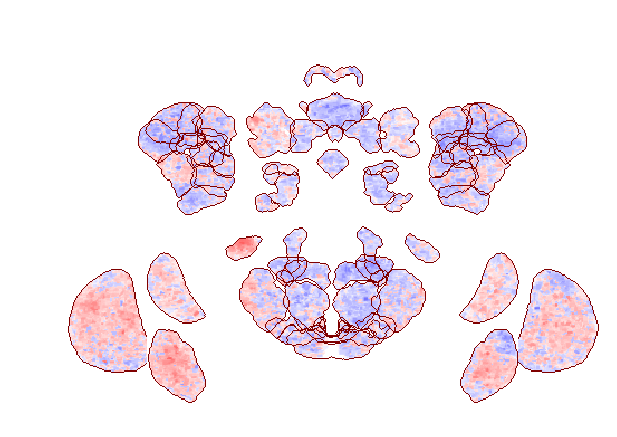

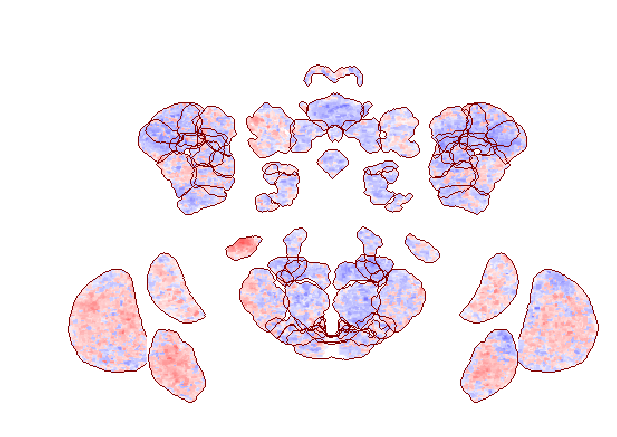

In [362]:
# BONUS: get exploded diagram of a few timepoints
for tp in range(50):
    print(tp)
    to_plot_new_ants = ants.from_numpy(corr_map[:,:,:,tp])
    to_plot_new_ants = ants.resample_image(to_plot_new_ants,(314, 146, 91),use_voxels=True,interp_type=0)
    corr = to_plot_new_ants.numpy()
    corr.shape

    input_canvas = np.zeros((500,500))
    #input_canvas = np.zeros((500,500)) #pca

    x_shift=0; y_shift=0
    data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=0; y_shift=-45
    data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
    canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=0; y_shift=35
    data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    ##########
    ### MB ###
    ##########

    # x_shift=60; y_shift=-50
    # data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
    # canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    # x_shift=-60; y_shift=-50
    # data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
    # canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    #################
    ### BIG GROUP ###
    #################

    x_shift=-130; y_shift=30
    data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=130; y_shift=30
    data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    ##############
    ### VISUAL ###
    ##############

    x_shift=-200; y_shift=175
    data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=200; y_shift=175
    data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=-140; y_shift=40+175
    data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=140; y_shift=40+175
    data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    x_shift=-140; y_shift=-30+175
    data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    x_shift=140; y_shift=-30+175
    data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

    canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
    canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

    canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

    canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
    canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)

    canvas[np.where(canvas==0)] = np.nan

    plt.figure(figsize=(10,10))
    plt.imshow(canvas[150:,:],cmap='seismic',vmin=-0.004,vmax=0.004)
    #plt.imshow(canvas[150:,:],cmap=cmap_new,vmin=1,vmax=n_clusters)

    plt.axis('off')

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210809_movie'
    label = format(tp, '02d')
    fname = os.path.join(save_path, f'{label}')
    # timestr = time.strftime("%Y%m%d-%H%M%S")
    # fname = os.path.join(save_path, f'{timestr}')
    plt.savefig(fname,dpi=300,bbox_inches='tight')

In [360]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210809_movie'
os.mkdir(save_path)

In [340]:
np.max(np.nan_to_num(canvas))

1.0

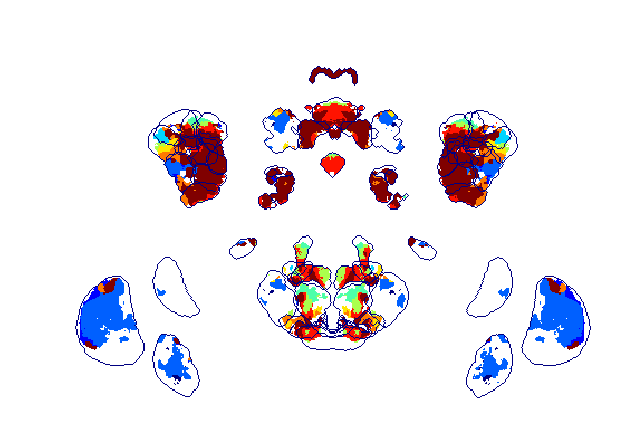

In [112]:
plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],cmap=cmap,vmin=1,vmax=n_clusters)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}_zneg_unique')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [2]:
fly_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_094/func_0'
fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))


~~ load_fictrac ~~
load_fictrac done. Duration: 2.91 sec


In [3]:
out = np.asarray(fictrac_raw['dRotLabZ'])
out.shape

(90000,)

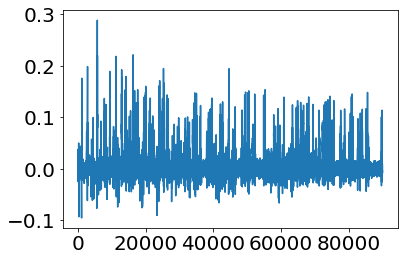

In [4]:
plt.plot(out)

In [5]:
1

1